# **1. Imports & Setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# **2. Load Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/TARUMT_DegreeInDataScience/Y2S1/AI/Assignment/fake_job_postings.csv'
df = pd.read_csv(file_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [4]:
df.shape

(17880, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [6]:
df.isnull().sum().sort_values(ascending=False)

,0
salary_range,15012
department,11547
required_education,8105
benefits,7212
required_experience,7050
function,6455
industry,4903
employment_type,3471
company_profile,3308
requirements,2696


In [7]:
print("Missing Percent (%): ")
df.isnull().sum().sort_values(ascending=False) / len(df.index)*100

Missing Percent (%): 


,0
salary_range,83.959732
department,64.580537
required_education,45.329978
benefits,40.335570
required_experience,39.429530
function,36.101790
industry,27.421700
employment_type,19.412752
company_profile,18.501119
requirements,15.078300


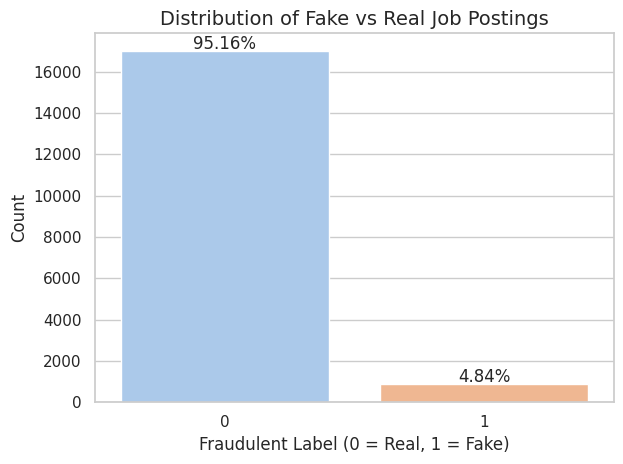

,count
fraudulent,
0,17014
1,866


In [8]:
# Set style
sns.set(style="whitegrid")

# Count each label
label_counts = df['fraudulent'].value_counts()
total = len(df)

# Create figure and bar plot
ax = sns.countplot(x='fraudulent', data=df, palette='pastel')

# Add percentage labels on top of each bar
for p in ax.patches:
    count = int(p.get_height())
    percentage = f'{100 * count / total:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + 100), ha='center', fontsize=12)

# Set axis labels and title
ax.set_xlabel("Fraudulent Label (0 = Real, 1 = Fake)", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Distribution of Fake vs Real Job Postings", fontsize=14)

plt.tight_layout()
plt.show()

df['fraudulent'].value_counts()

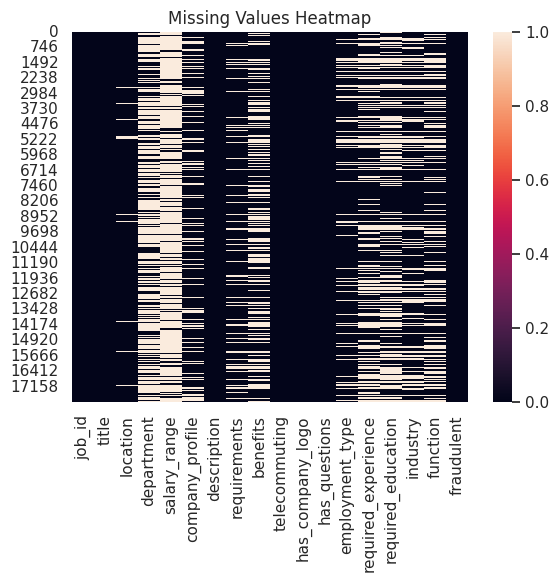

In [9]:
# view missing value
sns.heatmap(df.isna(), cbar=True)
plt.title("Missing Values Heatmap")
plt.show()

In [10]:
df.describe(include ='object')

,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function
count,17880,17534,6333,2868,14572,17879,15184,10668,14409,10830,9775,12977,11425
unique,11231,3105,1337,874,1709,14801,11967,6204,5,7,13,131,37
top,English Teacher Abroad,"GB, LND, London",Sales,0-0,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology
freq,311,718,551,142,726,379,410,726,11620,3809,5145,1734,1749


In [11]:
df['title'].value_counts()

,count
title,
English Teacher Abroad,311
Customer Service Associate,146
Graduates: English Teacher Abroad (Conversational),144
English Teacher Abroad,95
Software Engineer,86
...,...
iOS Developer Training,1
Sr. Android Software Engineer,1
Product Marketing Strategist,1


In [12]:
df['location'].value_counts()

,count
location,
"GB, LND, London",718
"US, NY, New York",658
"US, CA, San Francisco",472
"GR, I, Athens",464
"US, ,",339
...,...
"US, MA, Bourne",1
"US, NJ, Vineland",1
"US, FL, Fort Worth",1


In [13]:
df.describe(include='all')

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
count,17880.000000,17880,17534,6333,2868,14572,17879,15184,10668,17880.000000,17880.000000,17880.000000,14409,10830,9775,12977,11425,17880.000000
unique,NaN,11231,3105,1337,874,1709,14801,11967,6204,NaN,NaN,NaN,5,7,13,131,37,NaN
top,NaN,English Teacher Abroad,"GB, LND, London",Sales,0-0,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,NaN,NaN,NaN,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,NaN
freq,NaN,311,718,551,142,726,379,410,726,NaN,NaN,NaN,11620,3809,5145,1734,1749,NaN
mean,8940.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042897,0.795302,0.491723,NaN,NaN,NaN,NaN,NaN,0.048434
std,5161.655742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202631,0.403492,0.499945,NaN,NaN,NaN,NaN,NaN,0.214688
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,4470.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
50%,8940.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
75%,13410.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000


# **3. Data Exploration and Preprocessing**

In [14]:
#check duplicate
print("Duplicate rows:", df.duplicated().sum())

#check missing value each column
print("\nMissing values:\n", df.isnull().sum())

#check missing percent each column
missing_percent = df.isnull().mean() * 100
print("\n\n\n\nMissing Percent (%): \n")
print(missing_percent)

Duplicate rows: 0

Missing values:
 job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64




Missing Percent (%): 

job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employ

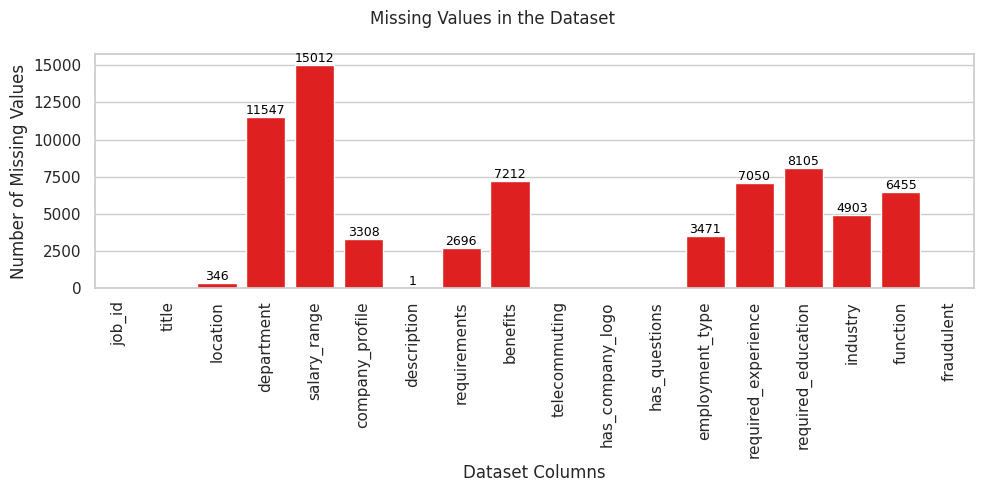

In [15]:
null_values = df.isnull().sum()

# Plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=null_values.index, y=null_values, color='red')

# Title and labels
plt.suptitle('Missing Values in the Dataset', size=12)
plt.xlabel('Dataset Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=90)

# Add value labels on top of each bar
for p in ax.patches:
    value = int(p.get_height())
    if value > 0:
        ax.text(p.get_x() + p.get_width() / 2, value + 0.5,
                str(value), ha='center', va='bottom', fontsize=9, color='black')


plt.tight_layout()
plt.show()

In [16]:
#fill missing column

df['employment_type']=df['employment_type'].fillna('Employement Unavailable')
df['required_experience']=df['required_experience'].fillna('Experience Unavailable')
df['required_education']=df['required_education'].fillna('Required Unspecified')

<Axes: >

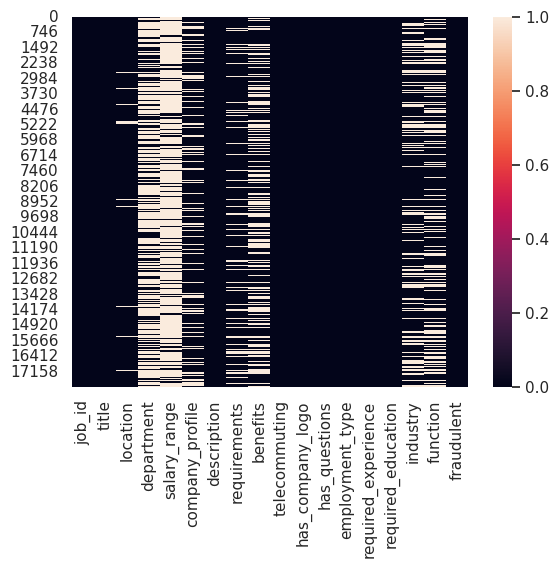

In [17]:
sns.heatmap(df.isnull(), cbar=True)

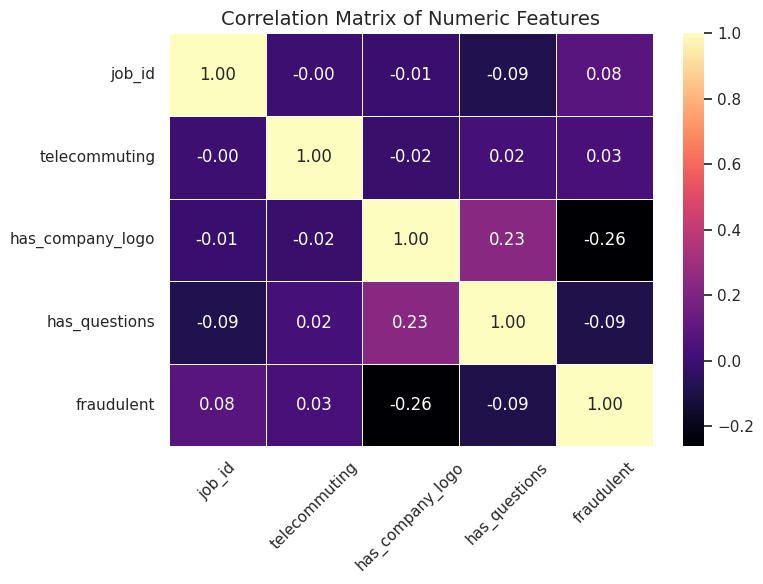

In [18]:
#check binary column that have relationship with faudelent

numeric_df = df.select_dtypes(include=['int64', 'float64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt=".2f", linewidths=0.5,
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)

plt.title('Correlation Matrix of Numeric Features', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Split 'location' into 'country', 'state', and 'city'
location_split = df['location'].str.split(',', expand=True)
df['country'] = location_split[0].str.strip()
df['state'] = location_split[1].str.strip() if location_split.shape[1] > 1 else None
df['city'] = location_split[2].str.strip() if location_split.shape[1] > 2 else None

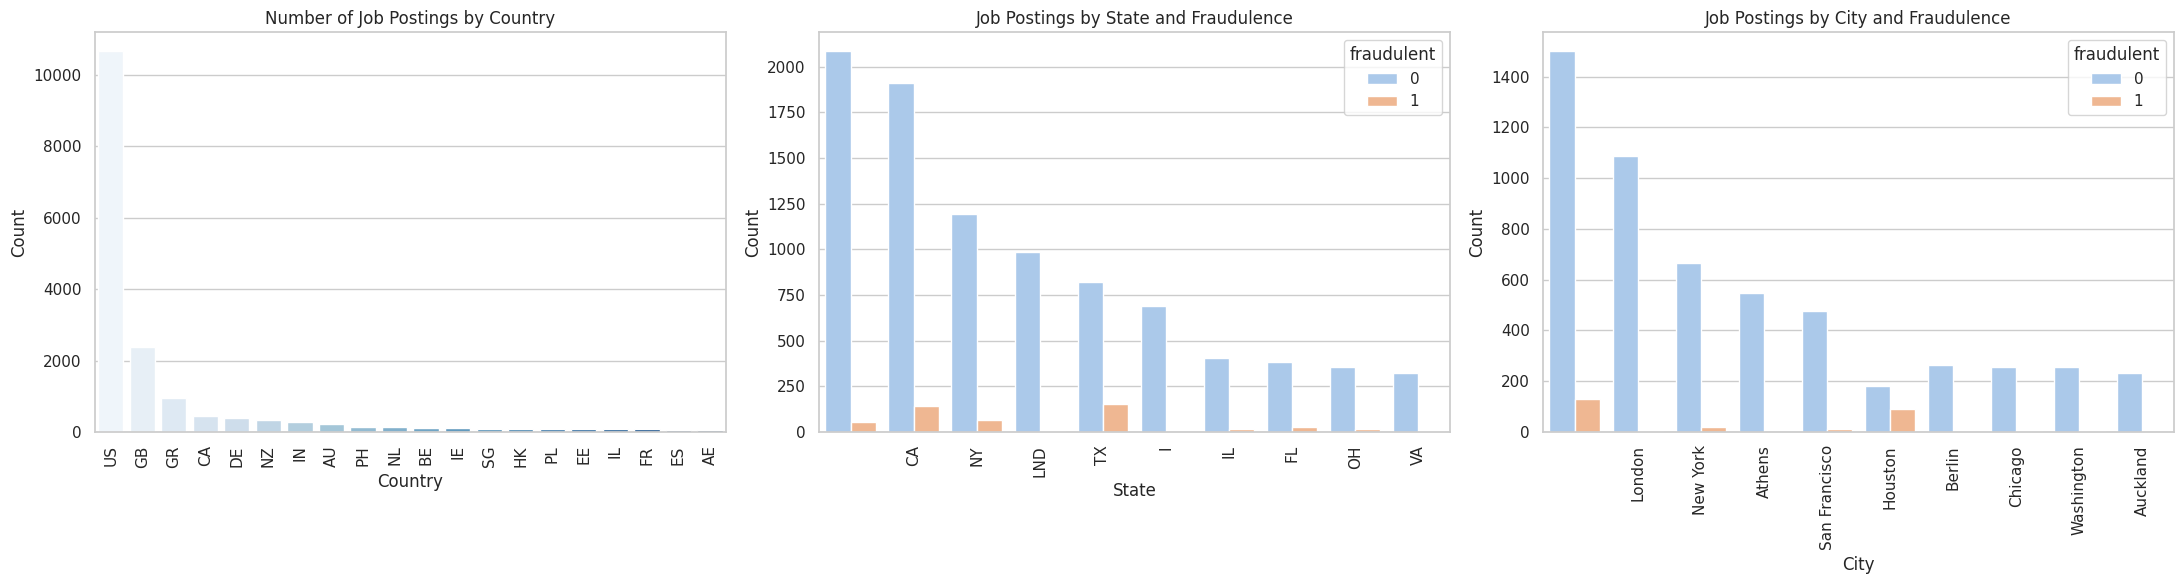

In [20]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(22, 6))

# 1. Plot by Country
country_order = df['country'].value_counts().head(20).index
sns.countplot(data=df[df['country'].isin(country_order)],
              x='country', order=country_order, ax=axs[0], palette='Blues')
axs[0].set_title('Number of Job Postings by Country')
axs[0].set_xlabel('Country')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=90)

# 2. Plot by State with Fraud Split
state_order = df['state'].value_counts().head(10).index
sns.countplot(data=df[df['state'].isin(state_order)],
              x='state', hue='fraudulent', order=state_order, ax=axs[1], palette='pastel')
axs[1].set_title('Job Postings by State and Fraudulence')
axs[1].set_xlabel('State')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=90)
axs[1].legend(title='fraudulent')

# 3. Plot by City with Fraud Split
city_order = df['city'].value_counts().head(10).index
sns.countplot(data=df[df['city'].isin(city_order)],
              x='city', hue='fraudulent', order=city_order, ax=axs[2], palette='pastel')
axs[2].set_title('Job Postings by City and Fraudulence')
axs[2].set_xlabel('City')
axs[2].set_ylabel('Count')
axs[2].tick_params(axis='x', rotation=90)
axs[2].legend(title='fraudulent')

plt.tight_layout()
plt.show()

Check about which type of experience is required in most number of jobs.

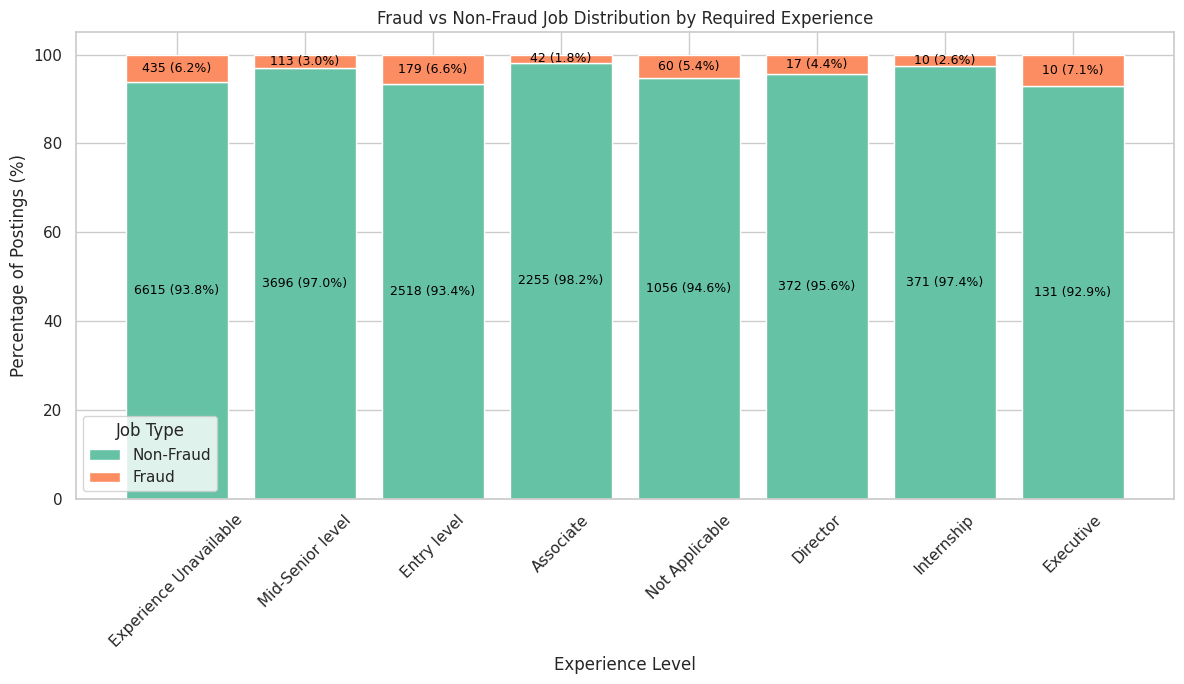

In [21]:
exp_counts = df.groupby(['required_experience', 'fraudulent']).size().unstack(fill_value=0)

# Sort by total occurrences
exp_counts = exp_counts.loc[exp_counts.sum(axis=1).sort_values(ascending=False).index]

# Calculate percentages
exp_percentages = exp_counts.div(exp_counts.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=(12, 7))

bottom = [0] * len(exp_counts)
colors = ['#66c2a5', '#fc8d62']  # fraud=0, fraud=1 colors

for i, fraud_value in enumerate([0, 1]):
    # Bar
    bars = ax.bar(
        exp_counts.index,
        exp_percentages[fraud_value],
        bottom=bottom,
        label='Non-Fraud' if fraud_value == 0 else 'Fraud',
        color=colors[i]
    )

    # Label text
    for j, bar in enumerate(bars):
        if exp_percentages[fraud_value].iloc[j] > 1:  # Only label if > 1%
            count = exp_counts[fraud_value].iloc[j]
            pct = exp_percentages[fraud_value].iloc[j]
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bottom[j] + bar.get_height() / 2,
                f'{int(count)} ({pct:.1f}%)',
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )
    # Update bottom for stacking
    bottom = [a + b for a, b in zip(bottom, exp_percentages[fraud_value])]

# Final plot settings
ax.set_ylabel('Percentage of Postings (%)')
ax.set_xlabel('Experience Level')
ax.set_title('Fraud vs Non-Fraud Job Distribution by Required Experience')
ax.legend(title='Job Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

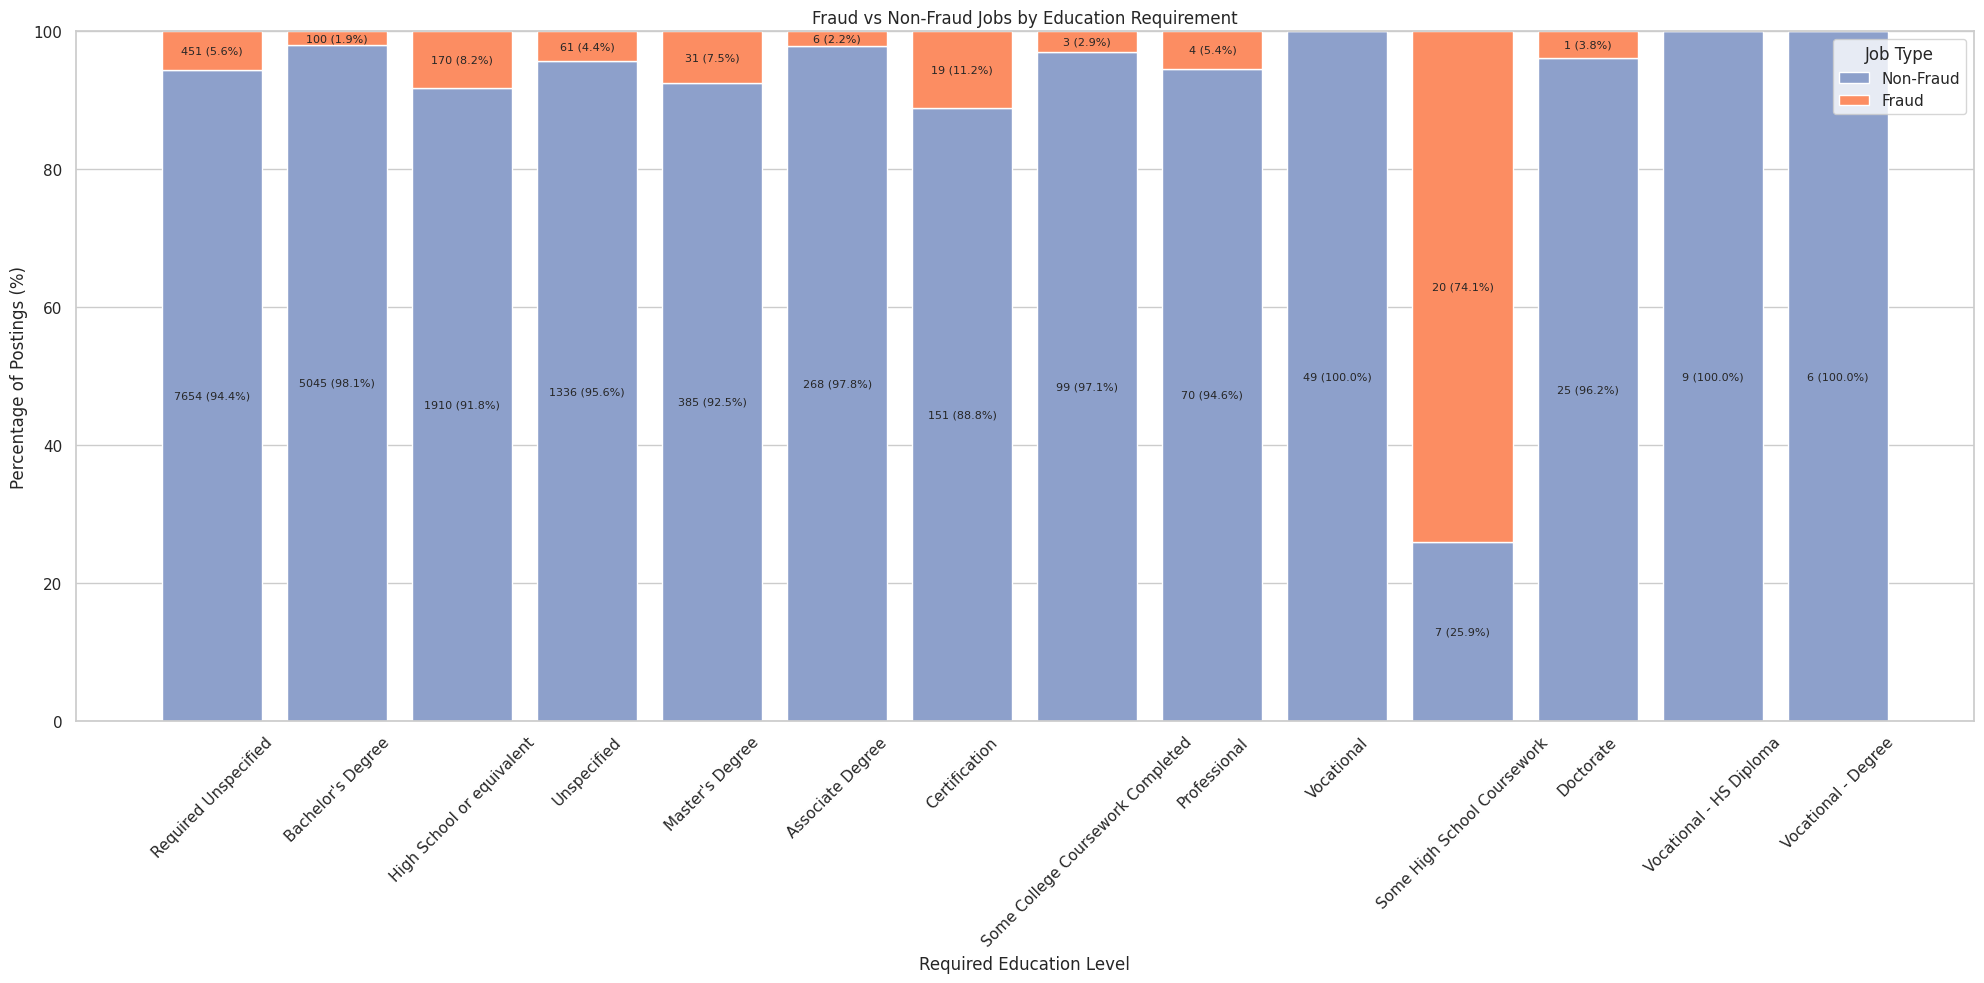

In [22]:
edu_counts = df.groupby(['required_education', 'fraudulent']).size().unstack(fill_value=0)

# Sort by total jobs
edu_counts = edu_counts.loc[edu_counts.sum(axis=1).sort_values(ascending=False).index]

# Convert counts to percentages
edu_percentages = edu_counts.div(edu_counts.sum(axis=1), axis=0) * 100

# Plot setup
fig, ax = plt.subplots(figsize=(20, 10))
bottom = [0] * len(edu_counts)
colors = ['#8da0cb', '#fc8d62']  # fraud=0: blue, fraud=1: orange

for i, fraud_value in enumerate([0, 1]):
    bars = ax.bar(
        edu_counts.index,
        edu_percentages[fraud_value],
        bottom=bottom,
        label='Non-Fraud' if fraud_value == 0 else 'Fraud',
        color=colors[i]
    )

    # Add labels to each bar segment
    for j, bar in enumerate(bars):
        if edu_percentages[fraud_value].iloc[j] > 1:  # Skip very small segments
            count = edu_counts[fraud_value].iloc[j]
            pct = edu_percentages[fraud_value].iloc[j]
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bottom[j] + bar.get_height() / 2,
                f'{int(count)} ({pct:.1f}%)',
                ha='center',
                va='center',
                fontsize=8
            )
    # Update bottom for stacking
    bottom = [a + b for a, b in zip(bottom, edu_percentages[fraud_value])]

# Aesthetics
ax.set_ylabel('Percentage of Postings (%)')
ax.set_xlabel('Required Education Level')
ax.set_title('Fraud vs Non-Fraud Jobs by Education Requirement')
ax.legend(title='Job Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

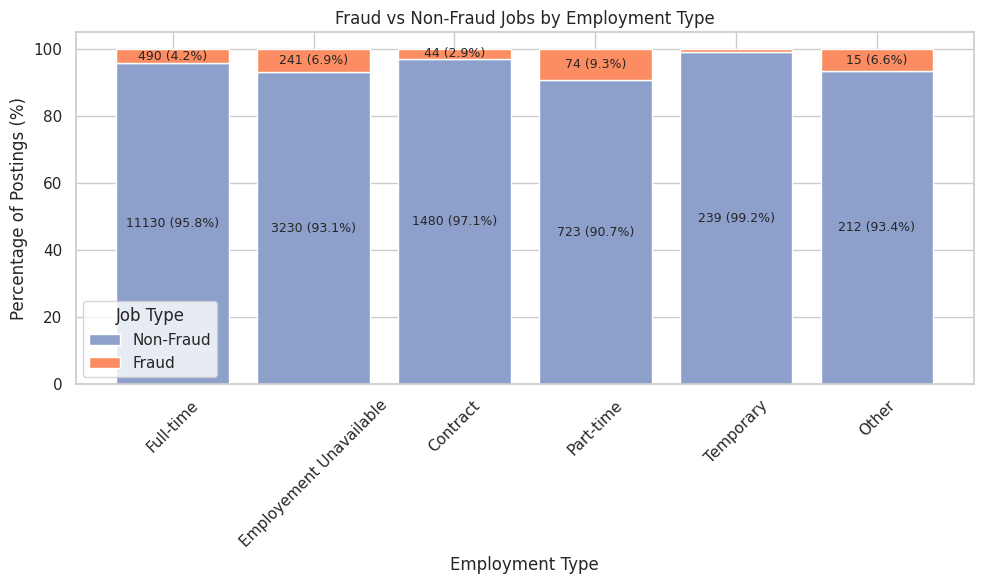

In [23]:
# Fill missing values
df['employment_type'] = df['employment_type'].fillna('Employment Unspecified')

# Group by employment type and fraud status
emp_counts = df.groupby(['employment_type', 'fraudulent']).size().unstack(fill_value=0)

# Sort by total postings
emp_counts = emp_counts.loc[emp_counts.sum(axis=1).sort_values(ascending=False).index]

# Convert to percentage
emp_percentages = emp_counts.div(emp_counts.sum(axis=1), axis=0) * 100

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bottom = [0] * len(emp_counts)
colors = ['#8da0cb', '#fc8d62']  # Non-Fraud, Fraud

for i, fraud_value in enumerate([0, 1]):
    bars = ax.bar(
        emp_counts.index,
        emp_percentages[fraud_value],
        bottom=bottom,
        label='Non-Fraud' if fraud_value == 0 else 'Fraud',
        color=colors[i]
    )

    # Add text labels to each bar
    for j, bar in enumerate(bars):
        pct = emp_percentages[fraud_value].iloc[j]
        count = emp_counts[fraud_value].iloc[j]
        if pct > 1:  # Only show for noticeable percentages
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bottom[j] + bar.get_height() / 2,
                f'{int(count)} ({pct:.1f}%)',
                ha='center',
                va='center',
                fontsize=9
            )
    # Update bottom for next stacked level
    bottom = [a + b for a, b in zip(bottom, emp_percentages[fraud_value])]

# Formatting
ax.set_title('Fraud vs Non-Fraud Jobs by Employment Type')
ax.set_ylabel('Percentage of Postings (%)')
ax.set_xlabel('Employment Type')
ax.legend(title='Job Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

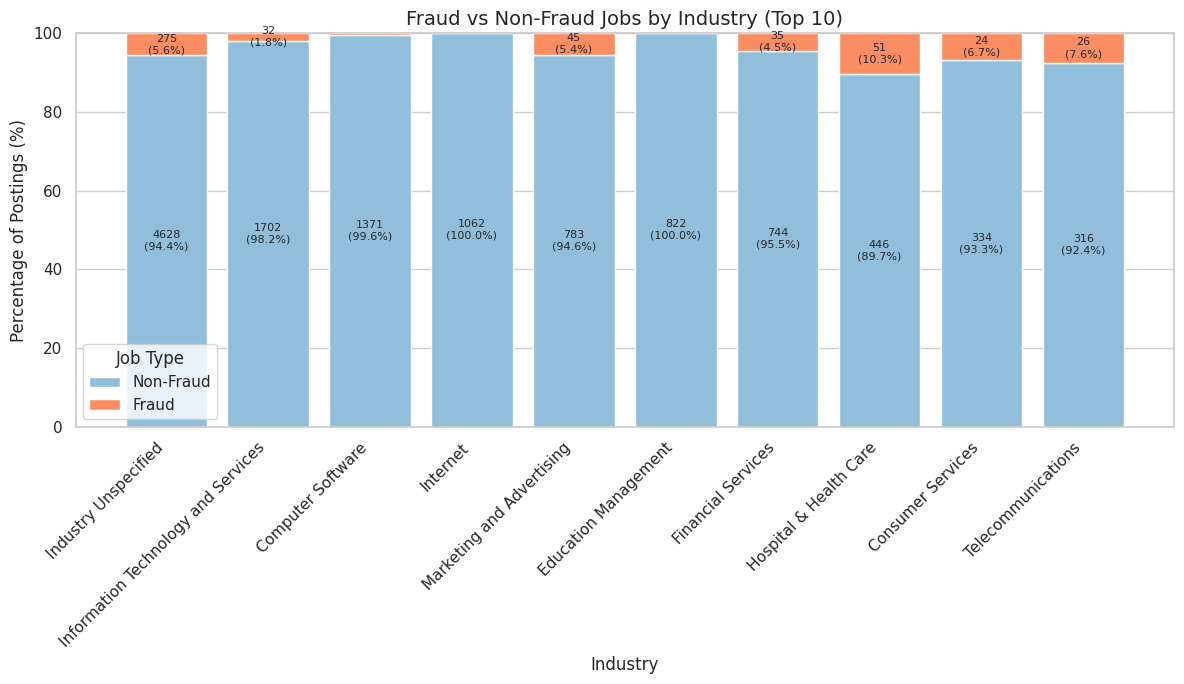

In [24]:
# Fill missing industries
df['industry'] = df['industry'].fillna('Industry Unspecified')

# Get top 10 industries by total job count
top_industries = df['industry'].value_counts().head(10).index
df_top = df[df['industry'].isin(top_industries)]

# Group and count
industry_counts = df_top.groupby(['industry', 'fraudulent']).size().unstack(fill_value=0)

# Sort industries by total postings
industry_counts = industry_counts.loc[industry_counts.sum(axis=1).sort_values(ascending=False).index]

# Convert to percentages
industry_percentages = industry_counts.div(industry_counts.sum(axis=1), axis=0) * 100

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
bottom = [0] * len(industry_counts)
colors = ['#91bfdb', '#fc8d62']  # Non-Fraud (0), Fraud (1)

for i, fraud_value in enumerate([0, 1]):
    bars = ax.bar(
        industry_counts.index,
        industry_percentages[fraud_value],
        bottom=bottom,
        label='Non-Fraud' if fraud_value == 0 else 'Fraud',
        color=colors[i]
    )

    # Add value + % labels
    for j, bar in enumerate(bars):
        pct = industry_percentages[fraud_value].iloc[j]
        count = industry_counts[fraud_value].iloc[j]
        if pct > 1:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bottom[j] + bar.get_height() / 2,
                f'{int(count)}\n({pct:.1f}%)',
                ha='center',
                va='center',
                fontsize=8
            )

    # Update bottom stack
    bottom = [a + b for a, b in zip(bottom, industry_percentages[fraud_value])]

# Formatting
ax.set_title('Fraud vs Non-Fraud Jobs by Industry (Top 10)', fontsize=14)
ax.set_ylabel('Percentage of Postings (%)')
ax.set_xlabel('Industry')
ax.legend(title='Job Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


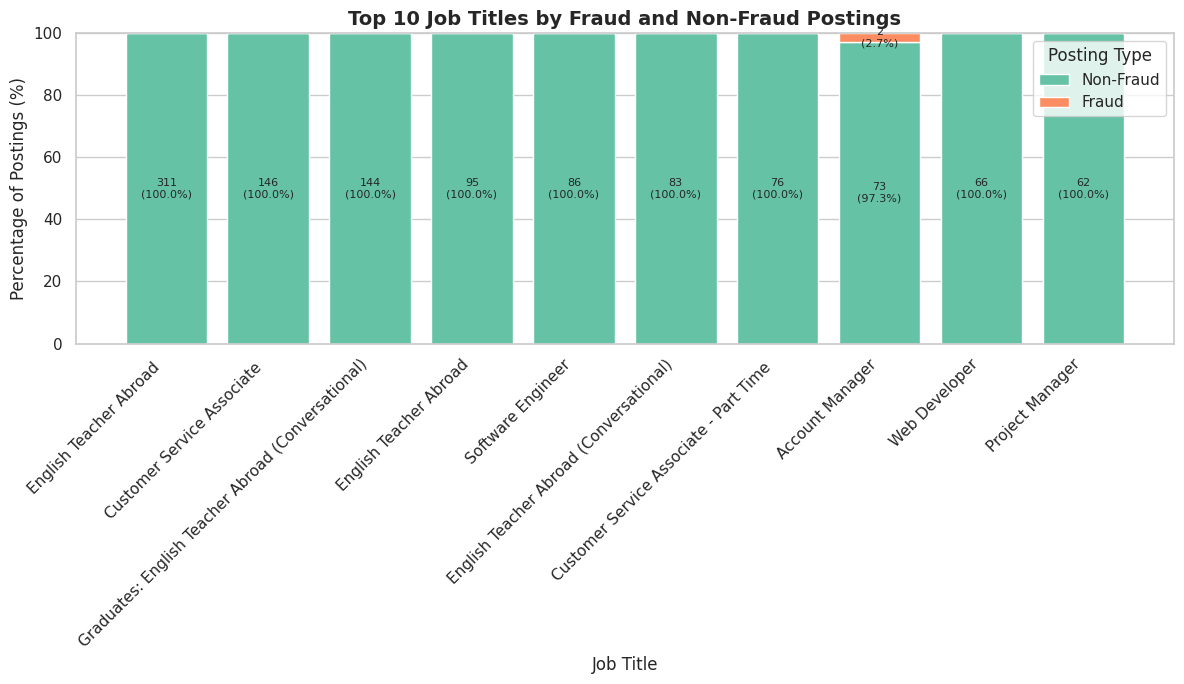

In [25]:
# Fill missing titles (if any)
df['title'] = df['title'].fillna('Title Unspecified')

# Get Top 10 job titles
top_titles = df['title'].value_counts().head(10).index
df_top_titles = df[df['title'].isin(top_titles)]

# Group and count: title vs fraudulent (0/1)
title_counts = df_top_titles.groupby(['title', 'fraudulent']).size().unstack(fill_value=0)

# Sort titles by total count
title_counts = title_counts.loc[title_counts.sum(axis=1).sort_values(ascending=False).index]

# Convert to % for each title
title_percentages = title_counts.div(title_counts.sum(axis=1), axis=0) * 100

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
bottom = [0] * len(title_counts)
colors = ['#66c2a5', '#fc8d62']  # 0 = non-fraud, 1 = fraud

for i, fraud_value in enumerate([0, 1]):
    bars = ax.bar(
        title_counts.index,
        title_percentages[fraud_value],
        bottom=bottom,
        label='Non-Fraud' if fraud_value == 0 else 'Fraud',
        color=colors[i]
    )

    # Add count + % labels
    for j, bar in enumerate(bars):
        pct = title_percentages[fraud_value].iloc[j]
        count = title_counts[fraud_value].iloc[j]
        if pct > 1:  # Show only if >1%
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bottom[j] + bar.get_height() / 2,
                f'{int(count)}\n({pct:.1f}%)',
                ha='center',
                va='center',
                fontsize=8
            )

    # Update bottom for stacked layout
    bottom = [a + b for a, b in zip(bottom, title_percentages[fraud_value])]

# Set titles and labels
ax.set_title('Top 10 Job Titles by Fraud and Non-Fraud Postings', fontsize=14, fontweight='bold')
ax.set_ylabel('Percentage of Postings (%)', fontsize=12)
ax.set_xlabel('Job Title', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Posting Type')
plt.tight_layout()
plt.show()


# **4. Clean Data & Drop Unused Columns**

In [26]:
#Drop columns that unused or missing value >= 50%

cols_to_drop = ['department','job_id','telecommuting','has_company_logo','has_questions']
df.drop(columns=cols_to_drop, inplace=True)

In [27]:
# Fill NaNs in text columns
text_columns = ['title', 'location','company_profile', 'description', 'requirements', 'benefits','industry','function']
for col in text_columns:
    df[col] = df[col].fillna('')

for idx in (df['salary_range'].dropna()).index :
    Range = df.at[idx , 'salary_range'].split('-')
    try :
        start = int(Range[0])
        if start < 1000 :
            df.at[idx ,'salary_range' ] = 0
        else :
            df.at[idx ,'salary_range' ] = start

    except ValueError :
        df.at[idx ,'salary_range' ] = 0

df['salary_range'] = df['salary_range'].fillna(0)

In [28]:
cols_to_drop = ['country','state','city']
df.drop(columns=cols_to_drop, inplace=True)

<Axes: >

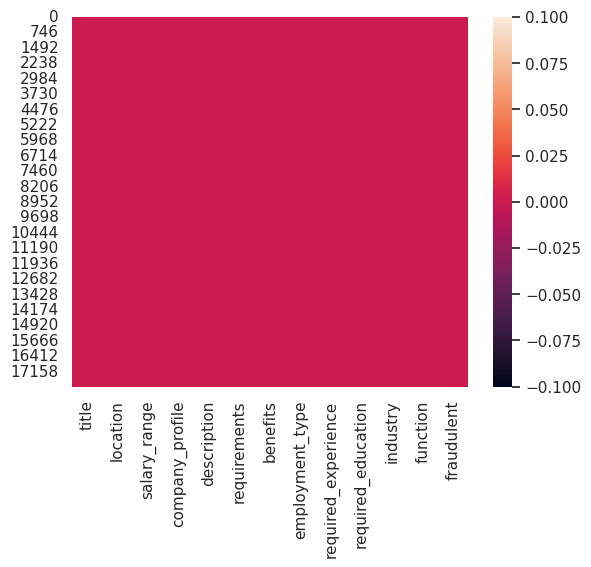

In [29]:
sns.heatmap(df.isna(), cbar=True)

# **5. Combine & Clean Text**

In [30]:
# Fill missing values with blank
text_columns = [
    'title', 'company_profile', 'description', 'requirements',
    'benefits', 'employment_type', 'required_experience',
    'required_education', 'industry', 'function'
]
df[text_columns] = df[text_columns].fillna('')

# Combine into one text column
df['combined_text'] = df[text_columns].apply(lambda row: ' '.join(row), axis=1)

In [31]:
df.combined_text

,combined_text
0,"Marketing Intern We're Food52, and we've creat..."
1,Customer Service - Cloud Video Production 90 S...
2,Commissioning Machinery Assistant (CMA) Valor ...
3,Account Executive - Washington DC Our passion ...
4,Bill Review Manager SpotSource Solutions LLC i...
...,...
17875,Account Director - Distribution Vend is looki...
17876,Payroll Accountant WebLinc is the e-commerce p...
17877,Project Cost Control Staff Engineer - Cost Con...
17878,Graphic Designer Nemsia Studios is looking fo...


In [32]:
import re
import spacy
import pandas as pd
from tqdm import tqdm


In [33]:
# Load spaCy with faster pipeline (disable parser and NER)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
tqdm.pandas()

def preprocess_text_basic(text):
    """Fast regex cleaning: remove HTML, URLs, digits, etc."""
    text = str(text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)
    return text.lower().strip()

def clean_texts_spacy_pipe(texts, batch_size=1000, n_process=2):
    """Parallel spaCy text cleaning with lemmatization + stopword removal."""
    cleaned_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=n_process), total=len(texts)):
        tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha and len(token) > 2]
        cleaned_texts.append(" ".join(tokens))
    return cleaned_texts

def clean_multiple_columns(df, columns):
    """
    Clean multiple columns and output new <col>_cleaned columns.
    """
    df_cleaned = df.copy()
    for col in columns:
        print(f"🧹 Cleaning column: {col}")
        # Step 1: Basic clean
        df_cleaned[f"{col}_basic"] = df_cleaned[col].fillna("").astype(str).progress_apply(preprocess_text_basic)
        # Step 2: spaCy bulk clean
        df_cleaned[f"{col}_cleaned"] = clean_texts_spacy_pipe(df_cleaned[f"{col}_basic"].tolist())
    return df_cleaned


In [34]:
#!!!!!!!!!!!!!!!!!!!!!!CAUTION : VERY SLOWWWW PROCESSING around 12-13minutes!!!!!!!!!!!!!!!!!!!!!!!!!!!
#df['cleaned_text'] = df['combined_text'].apply(clean_text_spacy)

In [35]:
# Define the columns to clean
columns_to_clean = ['title', 'company_profile', 'description', 'requirements', 'benefits']

# Run the cleaning
df_cleaned = clean_multiple_columns(df, columns_to_clean)


🧹 Cleaning column: title


100%|██████████| 17880/17880 [01:37<00:00, 182.83it/s]


🧹 Cleaning column: company_profile


100%|██████████| 17880/17880 [04:15<00:00, 70.08it/s] 


🧹 Cleaning column: description


100%|██████████| 17880/17880 [06:39<00:00, 44.71it/s] 


🧹 Cleaning column: requirements


100%|██████████| 17880/17880 [03:39<00:00, 81.36it/s] 


🧹 Cleaning column: benefits


100%|██████████| 17880/17880 [01:56<00:00, 153.07it/s]


In [36]:
df_cleaned.head()


,title,location,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,...,title_basic,title_cleaned,company_profile_basic,company_profile_cleaned,description_basic,description_cleaned,requirements_basic,requirements_cleaned,benefits_basic,benefits_cleaned
0,Marketing Intern,"US, NY, New York",0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Other,Internship,Required Unspecified,...,marketing intern,marketing intern,we re food and we ve created a groundbreaking...,food create groundbreaking award win cooking s...,food a fast growing james beard award winnin...,food fast grow james beard award win online fo...,experience with content management systems a m...,experience content management system major plu...,,
1,Customer Service - Cloud Video Production,"NZ, , Auckland",0,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,Required Unspecified,...,customer service cloud video production,customer service cloud video production,seconds the worlds cloud video production ser...,second world cloud video production service se...,organised focused vibrant awesome do you...,organise focused vibrant awesome passion custo...,what we expect from you your key responsibilit...,expect key responsibility communicate client s...,what you will get from usthrough being part of...,usthrough second team gain experience work pro...
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",0,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,Employement Unavailable,Experience Unavailable,Required Unspecified,...,commissioning machinery assistant cma,commission machinery assistant cma,valor services provides workforce solutions th...,valor service provide workforce solution meet ...,our client located in houston is actively se...,client locate houston actively seek experience...,implement pre commissioning and commissioning ...,implement pre commission commission procedure ...,,
3,Account Executive - Washington DC,"US, DC, Washington",0,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,...,account executive washington dc,account executive washington,our passion for improving quality of life thro...,passion improve quality life geography heart e...,the company esri environmental systems rese...,company esri environmental system research ins...,education bachelor s or master s in gis busi...,education bachelor master gis business adminis...,our culture is anything but corporate we have ...,culture corporate collaborative creative envir...
4,Bill Review Manager,"US, FL, Fort Worth",0,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,...,bill review manager,bill review manager,spotsource solutions llc is a global human cap...,spotsource solution llc global human capital m...,job title itemization review managerlocation ...,job title itemization review managerlocation f...,qualifications rn license in the state of texa...,qualification license state texasdiploma bache...,full benefits offered,benefit offer


Need improvement the time of executing

In [37]:
#for bert since bert model is better original text

from transformers import AutoTokenizer
import re

# Load tokenizer once, outside the function
tokenizer_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
do_lower_case = getattr(tokenizer, "do_lower_case", False)

def clean_text_for_bert(text):
    """
    Clean text for BERT input. Removes HTML, URLs, emails, phone numbers,
    special characters, and lowercases if model is uncased.
    """
    text = re.sub(r'<.*?>', '', str(text))  # Remove HTML tags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)  # Remove email addresses
    text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '', text)  # Phone numbers
    text = re.sub(r'[^\w\s.,!?-]', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace

    if do_lower_case:
        text = text.lower()

    return text

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [38]:
df['cleaned_text_bert'] = df['combined_text'].apply(clean_text_for_bert)

In [39]:
df.head().cleaned_text_bert

,cleaned_text_bert
0,"marketing intern we re food52, and we ve creat..."
1,customer service - cloud video production 90 s...
2,commissioning machinery assistant cma valor se...
3,account executive - washington dc our passion ...
4,bill review manager spotsource solutions llc i...


# **6. TF-IDF (Used for SVM or Naives Baiyes**

!!!!!Have 2 process for tf-idf
1. tf-idf for overall combined cleaned_text
2. tf-idf for 4 column
- title
- company profile
- benefit
- requirement

This is running for the cleaned_text column that have been combine

In [40]:
df_cleaned["combined_text_nb"] = (
    df_cleaned["title_cleaned"] + " " +
    df_cleaned["company_profile_cleaned"] + " " +
    df_cleaned["description_cleaned"] + " " +
    df_cleaned["requirements_cleaned"] + " " +
    df_cleaned["benefits_cleaned"]
)


In [41]:
def extract_tfidf_features(df_cleaned, text_column='combined_text_nb', label_column='fraudulent',
                           max_features=1000, ngram_range=(1,1)):

    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        stop_words=None
    )

    # Use df_cleaned consistently here
    X_tfidf = vectorizer.fit_transform(df_cleaned[text_column])
    y = df_cleaned[label_column]

    return X_tfidf, y, vectorizer


In [42]:
X_tfidf, y, tfidf_vectorizer = extract_tfidf_features(
    df_cleaned,
    text_column='combined_text_nb',
    label_column='fraudulent',
    max_features=1500,
    ngram_range=(1, 2)
)

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_tfidf_features(vectorizer, class_tfidf_matrix, top_n=20, class_label="TF-IDF Top Words"):
    """
    Visualizes the most frequent words in the TF-IDF matrix.

    Parameters:
    - vectorizer: The fitted TfidfVectorizer object.
    - class_tfidf_matrix: The TF-IDF matrix for the class (fraud or non-fraud).
    - top_n: Number of top features to display.
    - class_label: Title of the plot (for distinguishing between fraud and non-fraud).
    """
    # Get the feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Calculate the mean TF-IDF value for each word
    tfidf_means = np.asarray(class_tfidf_matrix.mean(axis=0)).flatten()

    # Select the top N features based on TF-IDF score
    top_indices = tfidf_means.argsort()[::-1][:top_n]
    top_features = [feature_names[i] for i in top_indices]
    top_scores = tfidf_means[top_indices]

    # Plot the top N features
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), top_scores[::-1], align='center')
    plt.yticks(range(top_n), top_features[::-1])
    plt.xlabel("Mean TF-IDF Score")
    plt.title(class_label)
    plt.tight_layout()
    plt.show()


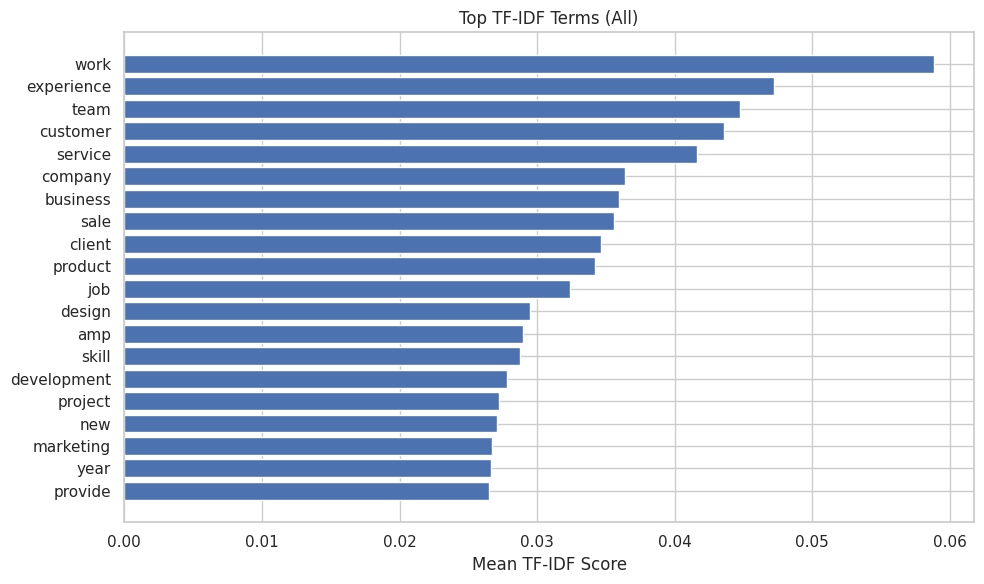

In [44]:
# Plot top TF-IDF words for all text
plot_top_tfidf_features(tfidf_vectorizer, X_tfidf, top_n=20, class_label="Top TF-IDF Terms (All)")

Compare tf-idf between 0 and 1

In [45]:
def plot_tfidf_by_class(df_cleaned, tfidf_matrix, vectorizer, label_column='fraudulent', top_n=20):
    """
    Compare the top TF-IDF words between the "fraudulent" and "non-fraudulent" classes.

    Parameters:
    - df: DataFrame with labels.
    - tfidf_matrix: TF-IDF matrix for the entire dataset.
    - vectorizer: The fitted TfidfVectorizer object.
    - label_column: The column that contains the labels ('fraudulent' or 'non-fraudulent').
    - top_n: Number of top features to display.
    """
    feature_names = vectorizer.get_feature_names_out()

    # Separate fraudulent and non-fraudulent samples
    fraud_mask = df[label_column] == 1
    legit_mask = df[label_column] == 0

    # Get the TF-IDF for each class
    fraud_tfidf = tfidf_matrix[fraud_mask.values]
    legit_tfidf = tfidf_matrix[legit_mask.values]

    # Calculate the mean TF-IDF score for each class
    fraud_means = np.asarray(fraud_tfidf.mean(axis=0)).flatten()
    legit_means = np.asarray(legit_tfidf.mean(axis=0)).flatten()

    # Get the top N indices for each class
    fraud_top_idx = fraud_means.argsort()[::-1][:top_n]
    legit_top_idx = legit_means.argsort()[::-1][:top_n]

    # Plotting
    plt.figure(figsize=(14, 6))

    # Plot top N features for fraud
    plt.subplot(1, 2, 1)
    plt.barh(range(top_n), fraud_means[fraud_top_idx][::-1])
    plt.yticks(range(top_n), [feature_names[i] for i in fraud_top_idx][::-1])
    plt.title("Top TF-IDF Terms - Fraudulent")
    plt.xlabel("TF-IDF Score")

    # Plot top N features for non-fraud
    plt.subplot(1, 2, 2)
    plt.barh(range(top_n), legit_means[legit_top_idx][::-1], color='green')
    plt.yticks(range(top_n), [feature_names[i] for i in legit_top_idx][::-1])
    plt.title("Top TF-IDF Terms - Non-Fraudulent")
    plt.xlabel("TF-IDF Score")

    plt.tight_layout()
    plt.show()


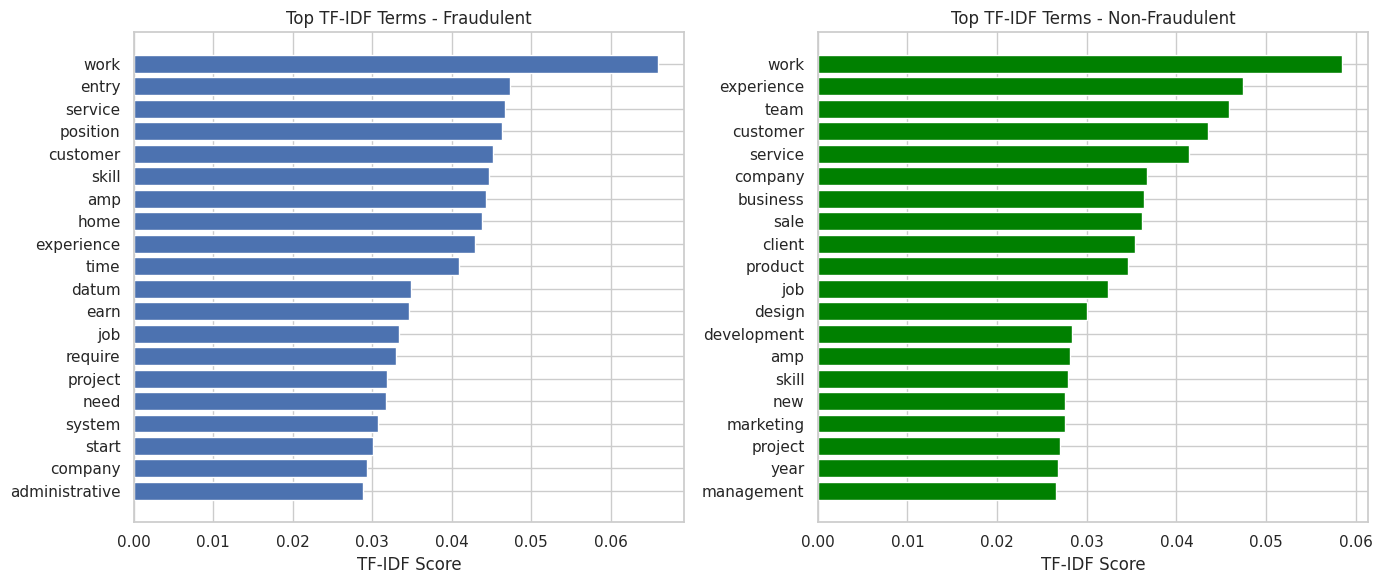

In [46]:
plot_tfidf_by_class(df_cleaned, X_tfidf, tfidf_vectorizer, label_column='fraudulent', top_n=20)

This is running for the every column that separate

specialize clean every column and generate <column>_cleaned. this is used to saw tf-idf for every column between 0 and 1

In [47]:
import re
import spacy
import pandas as pd
from tqdm import tqdm

# Load spaCy model and disable unused pipeline components for speed
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
tqdm.pandas()

def preprocess_text_basic(text):
    """
    Apply fast regex-based cleaning on raw text:
    - Remove HTML tags, URLs, emails, phone numbers, punctuation, digits
    - Convert to lowercase
    """
    text = str(text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text.strip()

def clean_texts_spacy_bulk(texts, batch_size=1000, n_process=2):
    """
    Perform spaCy lemmatization and stopword removal in bulk using nlp.pipe().
    """
    clean_texts = []
    for doc in nlp.pipe(texts, batch_size=batch_size, n_process=n_process):
        tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha and len(token) > 2]
        clean_texts.append(' '.join(tokens))
    return clean_texts

def clean_multiple_text_columns(df, columns):
    """
    Clean multiple text columns in a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to clean

    Returns:
    - cleaned_df: DataFrame with new columns like '<column>_cleaned'
    """
    cleaned_df = df.copy()
    for col in columns:
        print(f"Cleaning column: {col}")
        # Basic cleanup
        raw_clean = cleaned_df[col].fillna('').progress_apply(preprocess_text_basic)
        # spaCy lemmatization + stopword removal
        cleaned_text = clean_texts_spacy_bulk(raw_clean.tolist())
        cleaned_df[f"{col}_cleaned"] = cleaned_text
    return cleaned_df


In [48]:
columns_to_clean = ['title', 'company_profile', 'description', 'requirements']

# Apply the multi-column cleaning
df_cleaned = clean_multiple_text_columns(df, columns_to_clean)


Cleaning column: title


100%|██████████| 17880/17880 [00:00<00:00, 92248.05it/s]


Cleaning column: company_profile


100%|██████████| 17880/17880 [00:02<00:00, 6192.26it/s]


Cleaning column: description


100%|██████████| 17880/17880 [00:06<00:00, 2631.91it/s]


Cleaning column: requirements


100%|██████████| 17880/17880 [00:02<00:00, 6513.77it/s]


used 17 minutes to execute (**CLOWN**

In [49]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

def get_top_tfidf_words_by_class(df, text_column, label_column='fraudulent', top_n=15):
    """
    For a given text column, get top-N TF-IDF keywords for each class (fraudulent=0 and 1).

    Returns:
    - Two DataFrames: top words for class 0 and class 1
    """
    results = {}
    for label in [0, 1]:
        subset = df[df[label_column] == label]
        tfidf = TfidfVectorizer(max_features=5000)
        X = tfidf.fit_transform(subset[text_column])
        mean_tfidf = X.mean(axis=0).A1
        tfidf_scores = pd.Series(mean_tfidf, index=tfidf.get_feature_names_out())
        top_words = tfidf_scores.sort_values(ascending=False).head(top_n).reset_index()
        top_words.columns = ['word', 'tfidf']
        results[label] = top_words
    return results[0], results[1]


In [50]:
def plot_tfidf_bar(top_words, label, column_name):
    """
    Plot a bar chart of top TF-IDF words.
    """
    plt.figure(figsize=(10, 5))
    sns.barplot(x='tfidf', y='word', data=top_words, palette='viridis')
    plt.title(f"Top TF-IDF Words in '{column_name}' (fraudulent={label})")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()


Analyzing column: title_cleaned


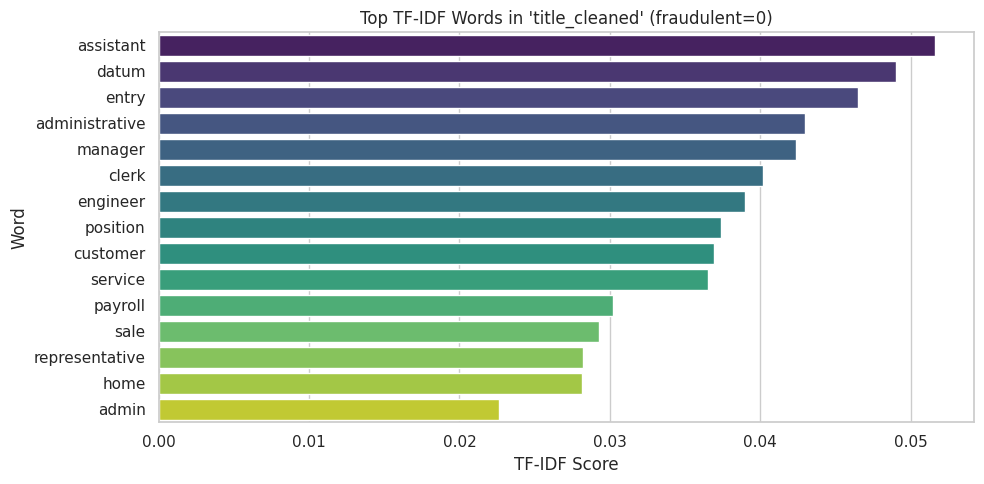

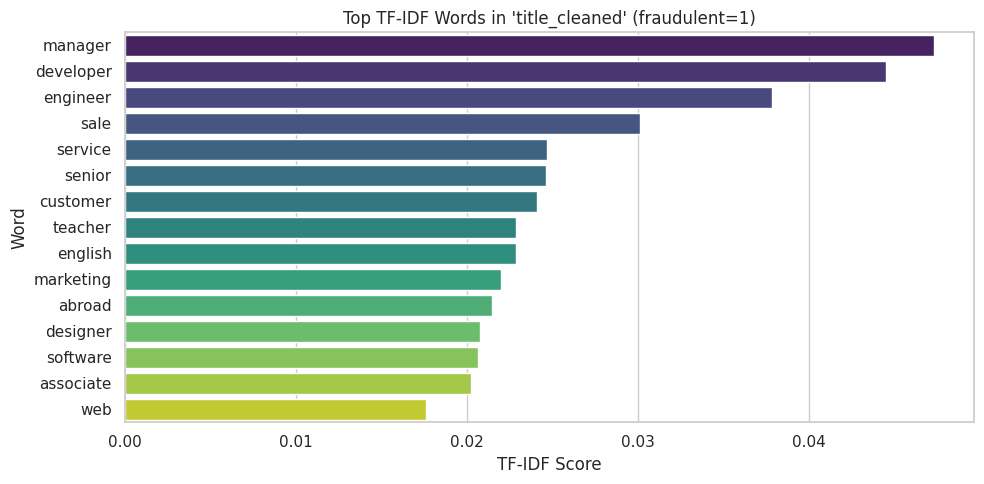

Analyzing column: company_profile_cleaned


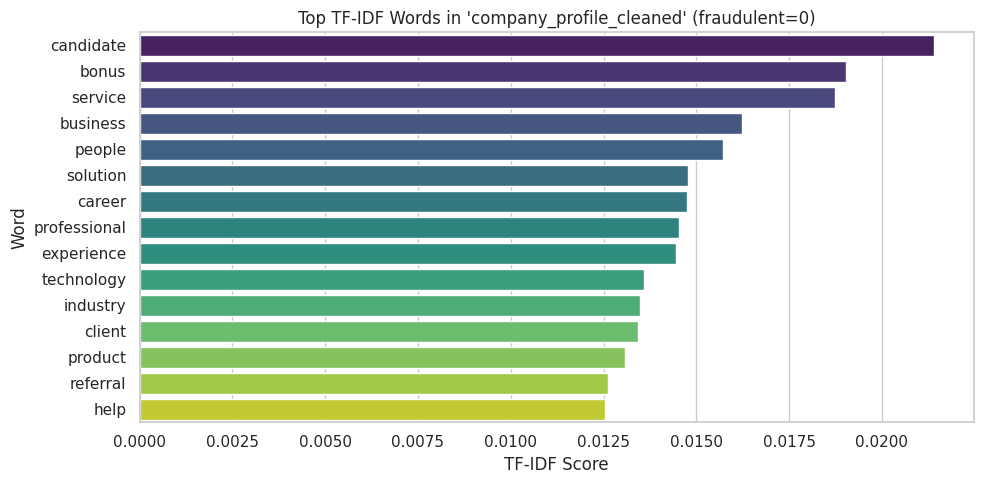

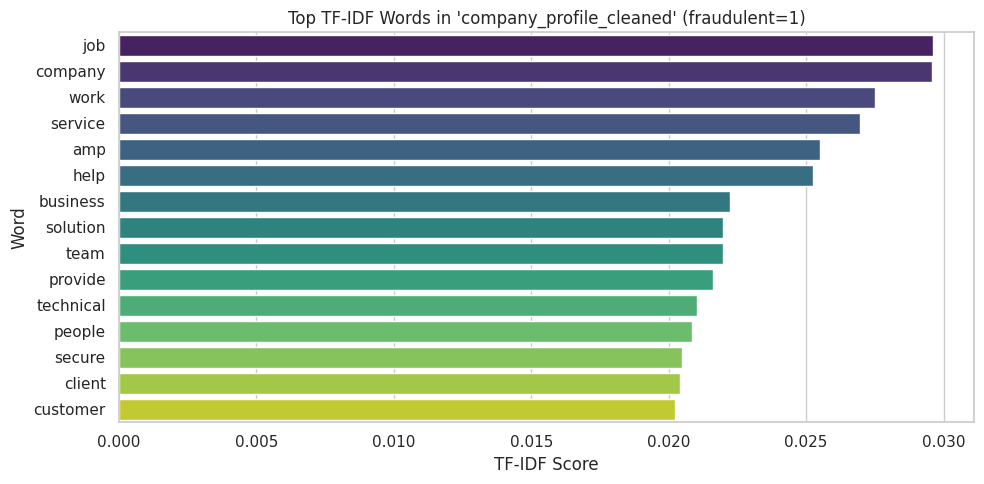

Analyzing column: description_cleaned


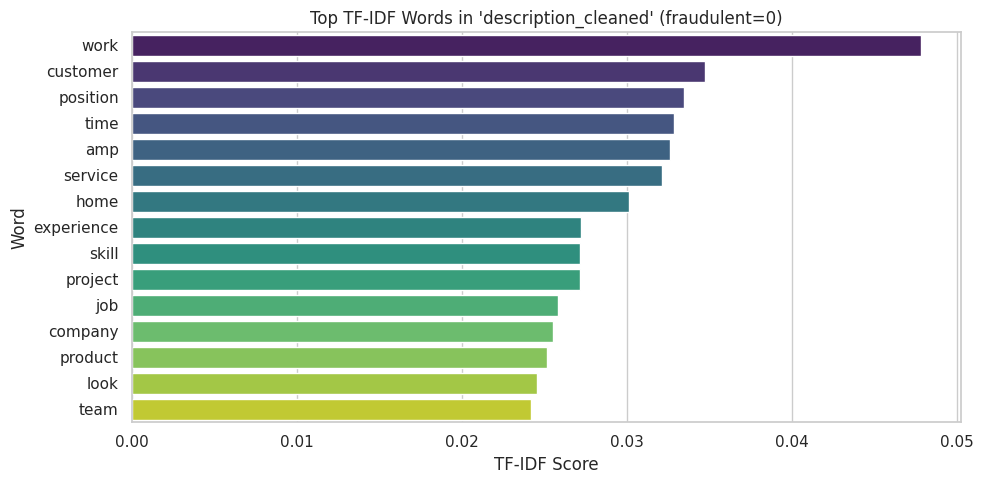

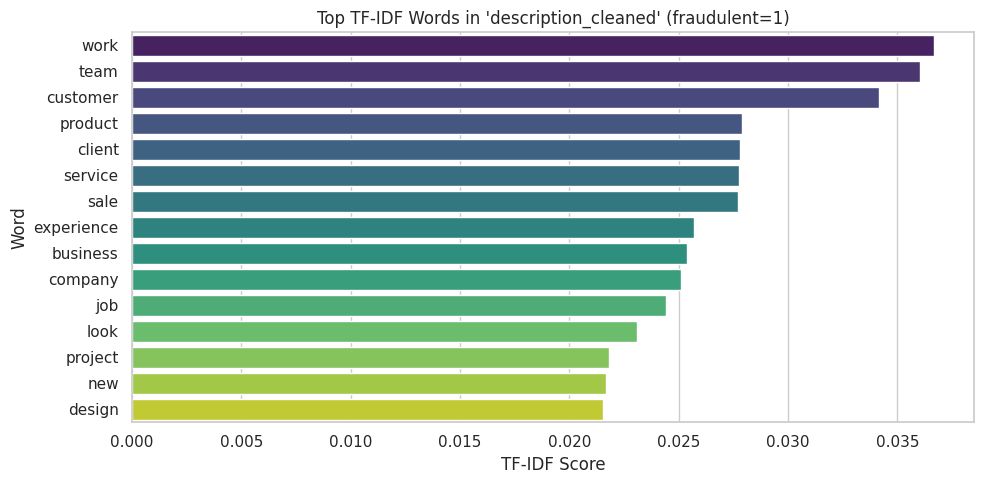

Analyzing column: requirements_cleaned


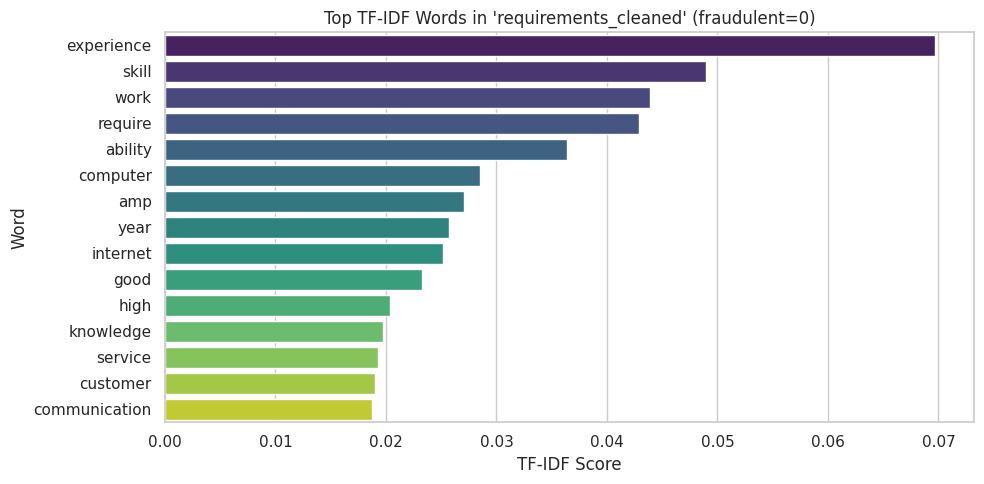

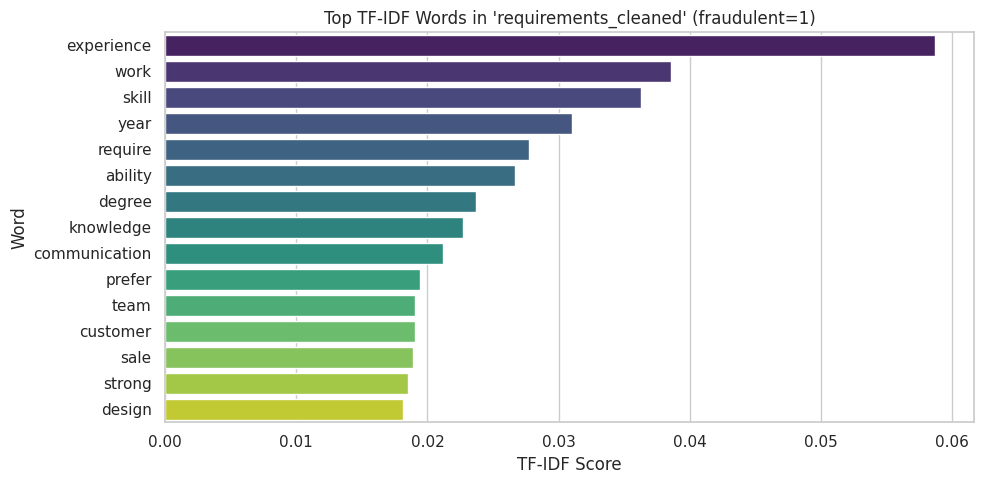

In [51]:
columns_to_analyze = ['title_cleaned', 'company_profile_cleaned', 'description_cleaned', 'requirements_cleaned']

for col in columns_to_analyze:
    print(f"Analyzing column: {col}")
    fraud_words, nonfraud_words = get_top_tfidf_words_by_class(df_cleaned, col)
    plot_tfidf_bar(nonfraud_words, label=0, column_name=col)
    plot_tfidf_bar(fraud_words, label=1, column_name=col)


In [52]:
pip install wordcloud


In [53]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_side_by_side_wordclouds(word_df_0, word_df_1, column_name):
    """
    Plot side-by-side word clouds for fraudulent=0 and fraudulent=1 for a given column.
    """
    freq_0 = dict(zip(word_df_0['word'], word_df_0['tfidf']))
    freq_1 = dict(zip(word_df_1['word'], word_df_1['tfidf']))

    wc_0 = WordCloud(width=600, height=400, background_color='white', colormap='Blues').generate_from_frequencies(freq_0)
    wc_1 = WordCloud(width=600, height=400, background_color='white', colormap='Reds').generate_from_frequencies(freq_1)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].imshow(wc_0, interpolation='bilinear')
    axs[0].axis('off')
    axs[0].set_title(f"{column_name}\nNon-Fraudulent (0)", fontsize=14)

    axs[1].imshow(wc_1, interpolation='bilinear')
    axs[1].axis('off')
    axs[1].set_title(f"{column_name}\nFraudulent (1)", fontsize=14)

    plt.tight_layout()
    plt.show()



--- title_cleaned ---


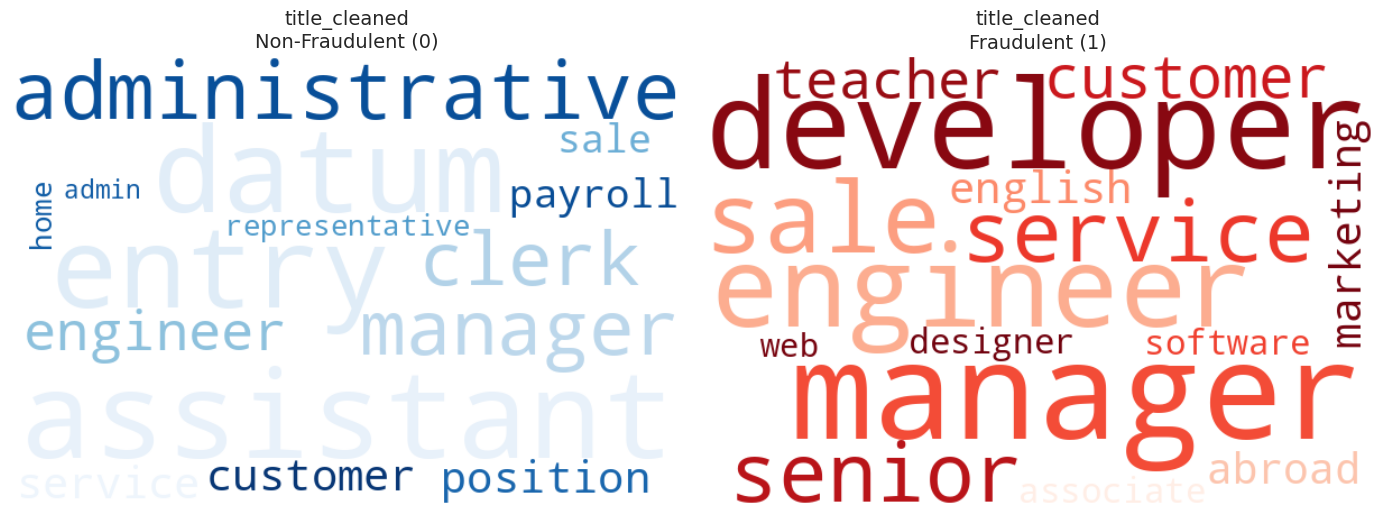


--- company_profile_cleaned ---


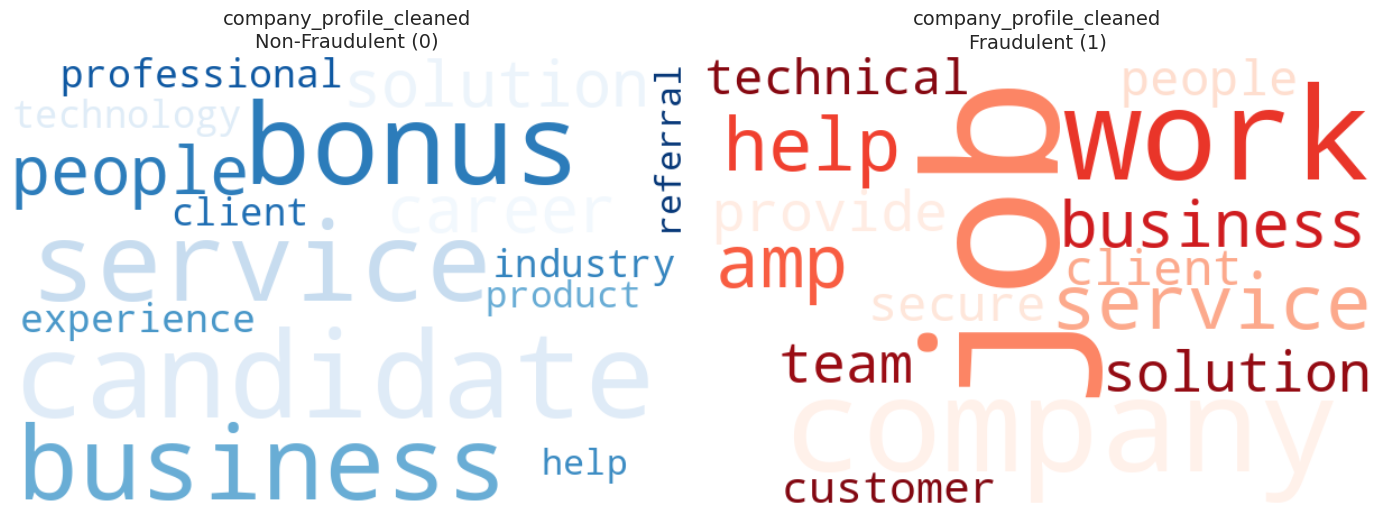


--- description_cleaned ---


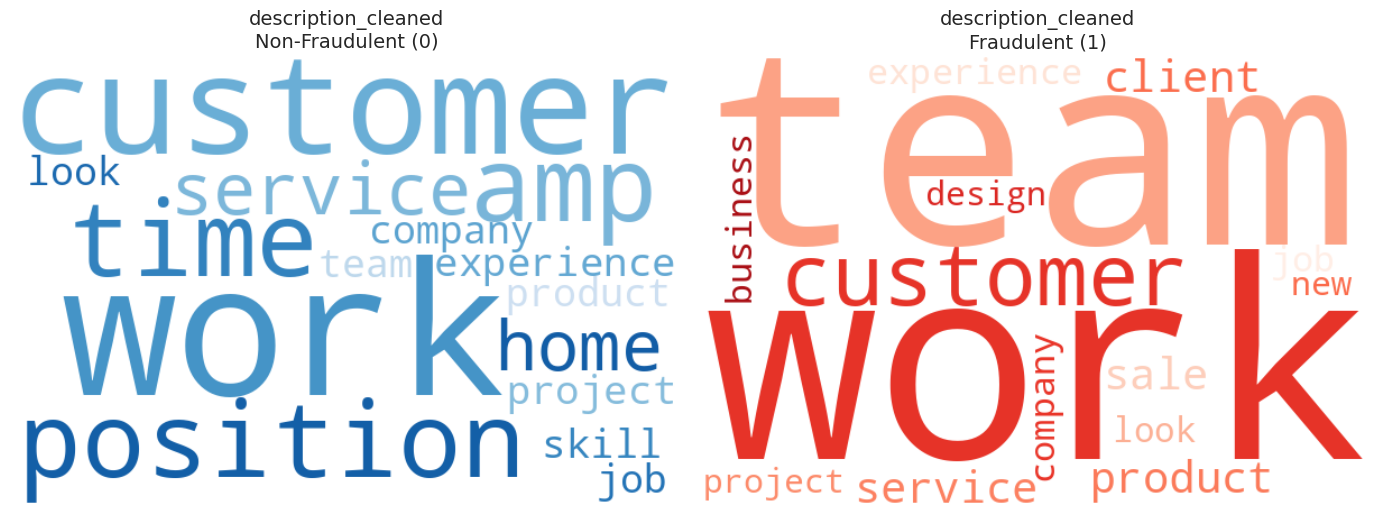


--- requirements_cleaned ---


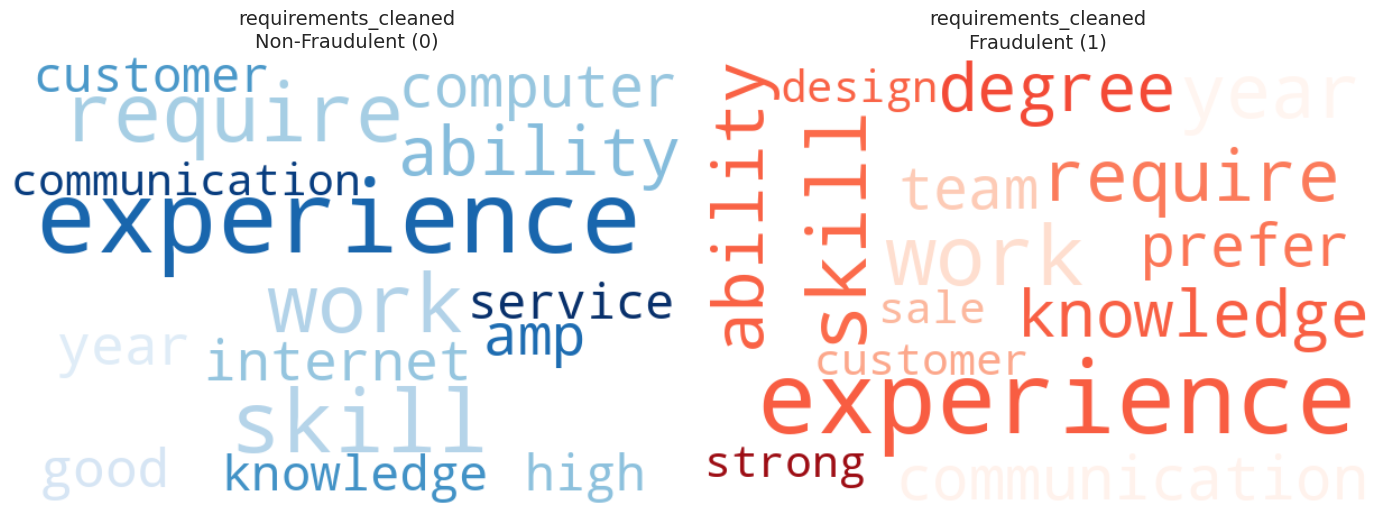

In [54]:
columns_to_analyze = [
    'title_cleaned',
    'company_profile_cleaned',
    'description_cleaned',
    'requirements_cleaned'
]

for col in columns_to_analyze:
    print(f"\n--- {col} ---")
    fraud_words, nonfraud_words = get_top_tfidf_words_by_class(df_cleaned, col)
    plot_side_by_side_wordclouds(nonfraud_words, fraud_words, column_name=col)


# **7. SMOTE**

train text split

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, roc_auc_score

In [56]:
df_cleaned['combined_text_smote'] = (
    df_cleaned['title_cleaned'] + ' ' +
    df_cleaned['company_profile_cleaned'] + ' ' +
    df_cleaned['description_cleaned'] + ' ' +
    df_cleaned['requirements_cleaned']
)

In [57]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_cleaned['combined_text_smote'])
y = df_cleaned['fraudulent']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [59]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

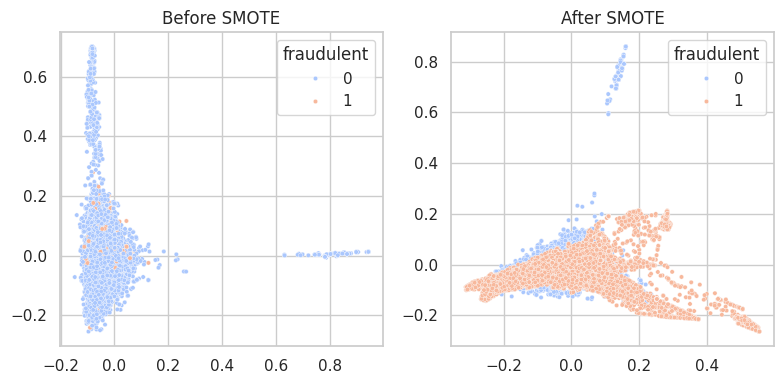

In [60]:
from sklearn.decomposition import PCA

# PCA on training set (before and after SMOTE)
pca = PCA(n_components=2)

X_pca_before = pca.fit_transform(X_train.toarray())
X_pca_after = pca.fit_transform(X_train_resampled.toarray())

# Plot before SMOTE
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca_before[:, 0], y=X_pca_before[:, 1], hue=y_train, palette='coolwarm', s=10)
plt.title("Before SMOTE")

# Plot after SMOTE
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca_after[:, 0], y=X_pca_after[:, 1], hue=y_train_resampled, palette='coolwarm', s=10)
plt.title("After SMOTE")

plt.tight_layout()
plt.show()


In [62]:
print("TF-IDF shape:", X_train_resampled.shape)

TF-IDF shape: (27222, 5000)


# **8. SVM & Naives Baiyes**

!!!!!!!!!!!!!!!!!!!!!TRAIN FIRST To check report ok or not!!!!!!!
I will delete these coding if report ok.
then you guys boleh train model already

**SVM**

In [65]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)

y_pred_svm = svm_model.predict(X_test)


print("🔎 SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("\n🧱 SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


🔎 SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.82      0.81      0.82       173

    accuracy                           0.98      3576
   macro avg       0.91      0.90      0.90      3576
weighted avg       0.98      0.98      0.98      3576


🧱 SVM Confusion Matrix:
[[3373   30]
 [  33  140]]


In [67]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


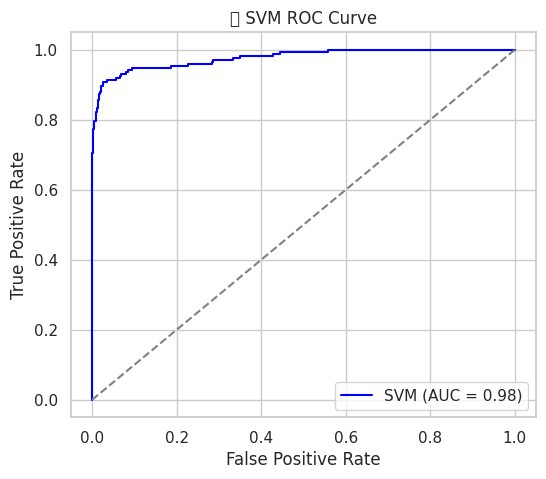

In [68]:
y_scores_svm = svm_model.decision_function(X_test)

# ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_scores_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(6, 5))
plt.plot(fpr_svm, tpr_svm, color='blue', label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('🔵 SVM ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Naive Bayes**

In [66]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_resampled, y_train_resampled)

y_pred_nb = nb_model.predict(X_test)

print("🔎 Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

print("\n🧱 Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))


🔎 Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      3403
           1       0.41      0.86      0.56       173

    accuracy                           0.93      3576
   macro avg       0.70      0.90      0.76      3576
weighted avg       0.96      0.93      0.94      3576


🧱 Naive Bayes Confusion Matrix:
[[3193  210]
 [  25  148]]


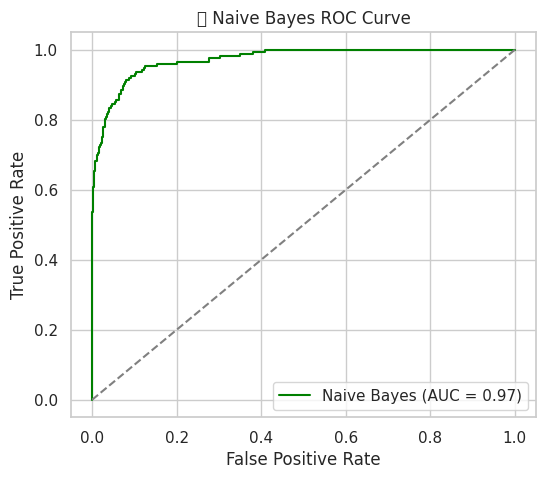

In [69]:
y_probs_nb = nb_model.predict_proba(X_test)[:, 1]

# ROC curve
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_probs_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_nb, tpr_nb, color='green', label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('🟢 Naive Bayes ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


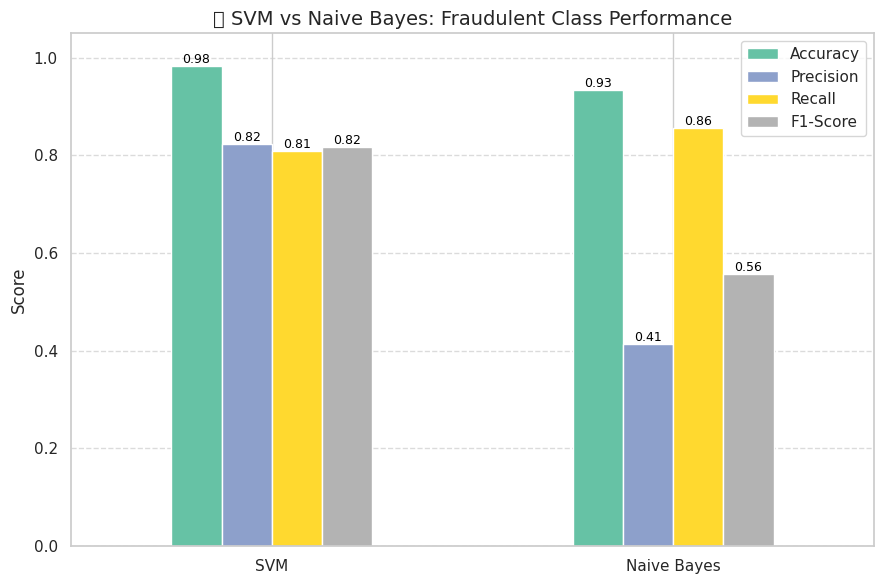

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

svm_report_dict = classification_report(y_test, y_pred_svm, output_dict=True)
nb_report_dict = classification_report(y_test, y_pred_nb, output_dict=True)

svm_metrics = {
    'Accuracy': svm_report_dict['accuracy'],
    'Precision': svm_report_dict['1']['precision'],
    'Recall': svm_report_dict['1']['recall'],
    'F1-Score': svm_report_dict['1']['f1-score']
}

nb_metrics = {
    'Accuracy': nb_report_dict['accuracy'],
    'Precision': nb_report_dict['1']['precision'],
    'Recall': nb_report_dict['1']['recall'],
    'F1-Score': nb_report_dict['1']['f1-score']
}

df_metrics = pd.DataFrame([svm_metrics, nb_metrics], index=['SVM', 'Naive Bayes'])

ax = df_metrics.plot(kind='bar', figsize=(9, 6), colormap='Set2')
plt.title('📊 SVM vs Naive Bayes: Fraudulent Class Performance', fontsize=14)
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)


for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


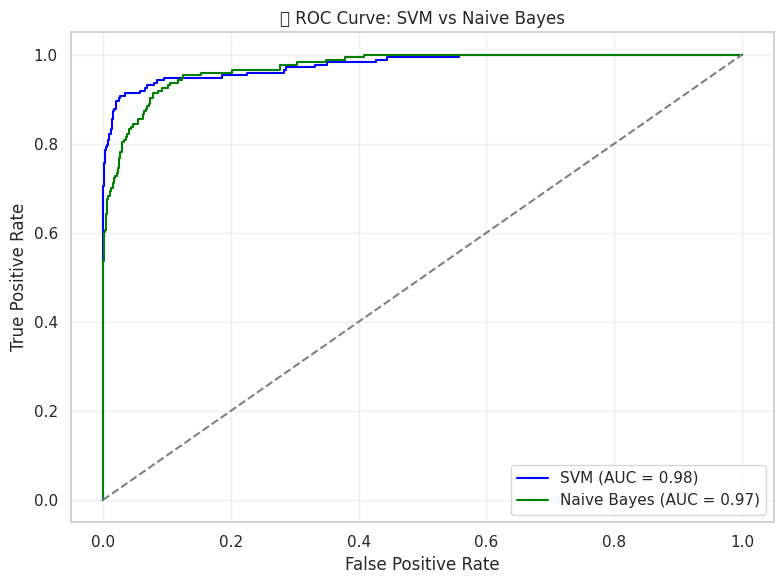

In [82]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

svm_probs = svm_model.decision_function(X_test)
nb_probs = nb_model.predict_proba(X_test)[:, 1]

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probs)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='blue', label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_nb, tpr_nb, color='green', label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('🔍 ROC Curve: SVM vs Naive Bayes')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Heatmap

In [70]:
def plot_confusion_heatmap(y_true, y_pred, title="Confusion Matrix", cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


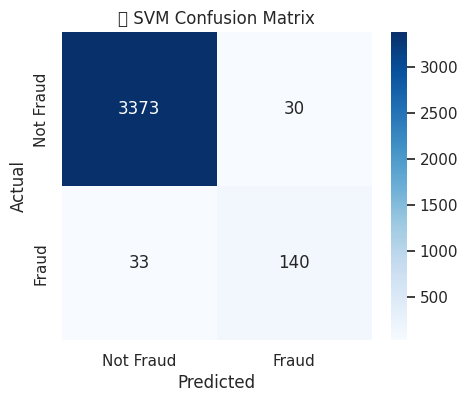

In [71]:
y_pred_svm = svm_model.predict(X_test)
plot_confusion_heatmap(y_test, y_pred_svm, title="🔷 SVM Confusion Matrix")


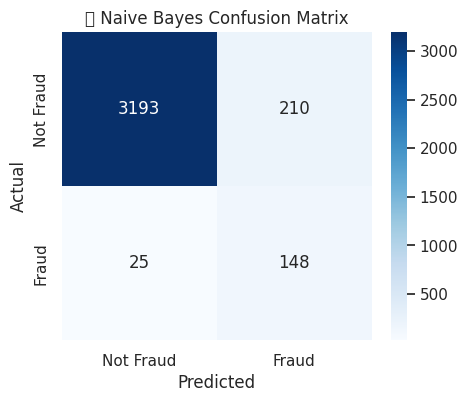

In [72]:
y_pred_nb = nb_model.predict(X_test)
plot_confusion_heatmap(y_test, y_pred_nb, title="🟩 Naive Bayes Confusion Matrix")


# **9. Bert**

must use cleaned_text_bert since bert model is required the basic clean and try to origial content